Test Jacobi-iterator for thermal problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair

import matplotlib.pyplot as plt
import math
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet


In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 1 # batch size
k = 0 # test data index
n_test = 2**6
test_set = MechanicalDataSet('data/Ti64/thermal_Ti64.h5', device)
# n_test = 2**5
# test_set = ThermalDataSet('data/thermal/thermal_test.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
mask_test, dirich_idx_test, dirich_value_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))
solution_test, f_test, d_test, d_idx_test, t_test, t_conn_test, m_test, msk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(mask_test[k], 0).to(device_predict))

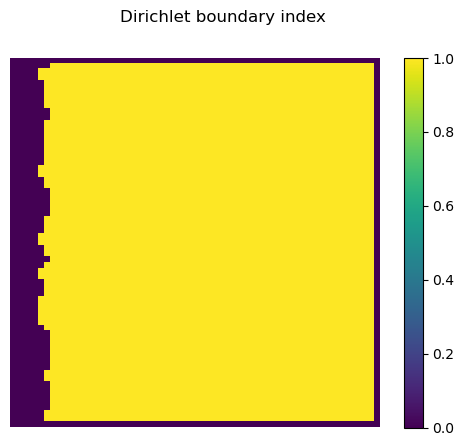

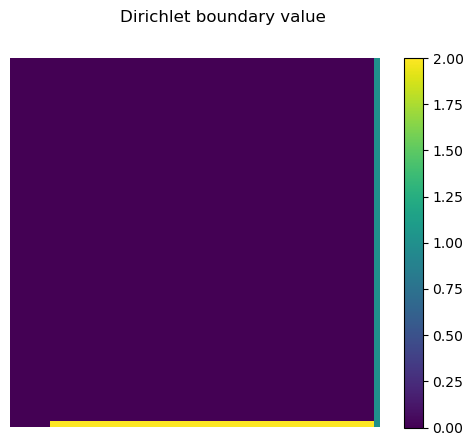

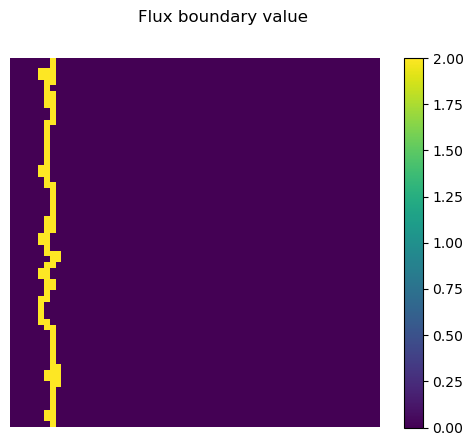

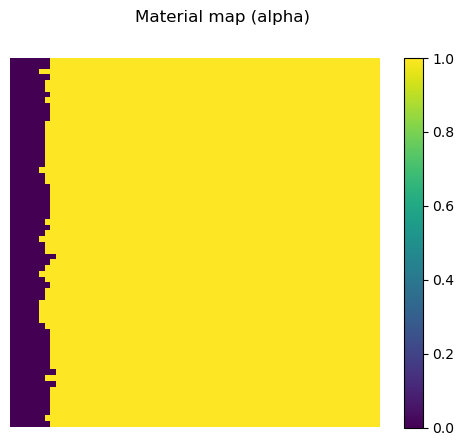

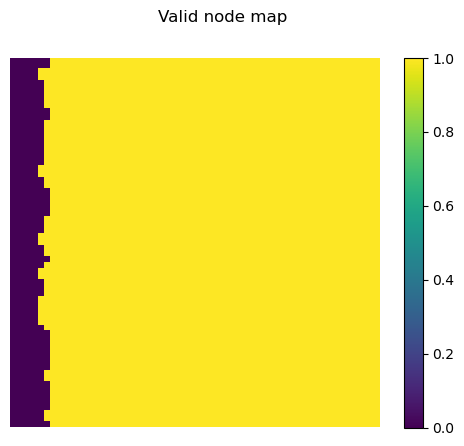

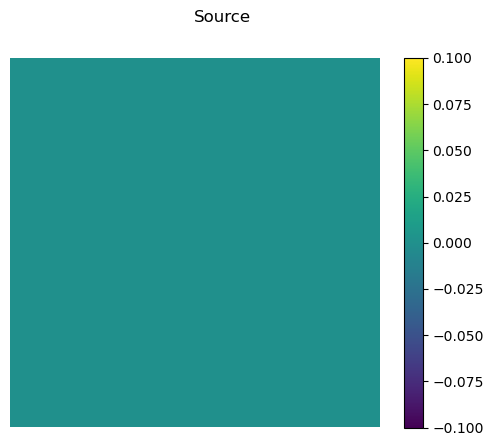

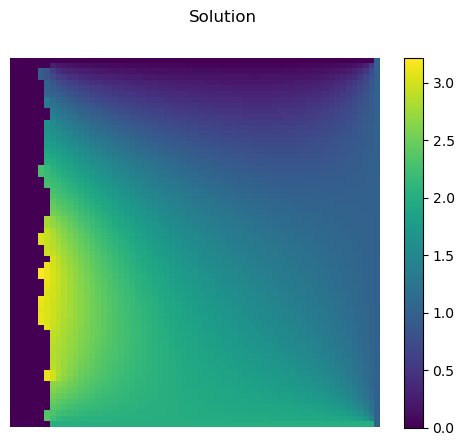

In [4]:
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

In [5]:
n_elem = n_test
ku, kf = 1, 1
h = 0.0061*4
grid = SingleGrid(h, n_elem=n_elem, mode='thermal', dev=device_predict)

In [6]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(False):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, msk_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_conn_test)
        residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_thermalfield(jacu_test[0], "Benchmark")
    plot.plot_thermalfield(solution_test[0], "Test")
    plot.plot_thermalfield(jacu_test[0]-solution_test[0], 'Error')

## Test multigrid performance

In [7]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, pacnet=None, device=device, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,msk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test,msk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 10.565256808984309
1 2.4175140750599664
2 0.7235060907269082
3 0.3719452357854872
4 0.2741808951296827
5 0.21848799901974958
6 0.1766774330284418
7 0.14352462243497574
8 0.11682873039020199
9 0.09519524658501112
10 0.07760996669178358
11 0.06329242243971657
12 0.05162525284320684
13 0.04211318424967697
14 0.03435593178636943
15 0.02802868538630716
16 0.02286729300369356
17 0.018656659970093435
18 0.015221507547653805
19 0.012418938400728557
20 0.010132422054263523
21 0.008266913184297823
22 0.006744881649372181
23 0.005503080153765068
24 0.004489910552948423
25 0.0036632769324709395
26 0.002988834969042144
27 0.0024385641491672275
28 0.00198960315336313
29 0.0016232998184813544
30 0.0013244360980956692
31 0.0010805957617208708
32 0.0008816485312146683
33 0.0007193292053586711
34 0.0005868942779145519
35 0.00047884177858479335
36 0.00039068269517834544
37 0.00031875447955706434
38 0.00026006888891577364
39 0.00021218784080001313
40 0.00017312212422998218
41 0.0001412487588344484
42 0.

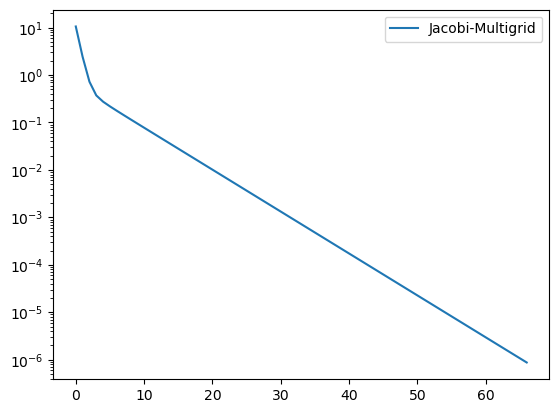

In [8]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

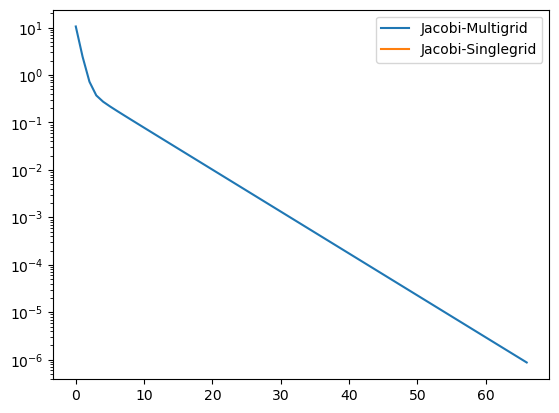

In [9]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr, label='Jacobi-Singlegrid')
plt.yscale('log')
plt.legend()
plt.show()

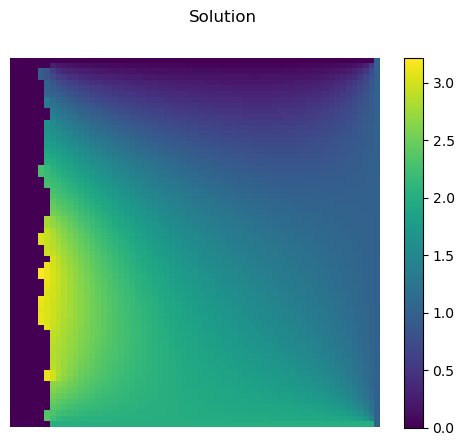

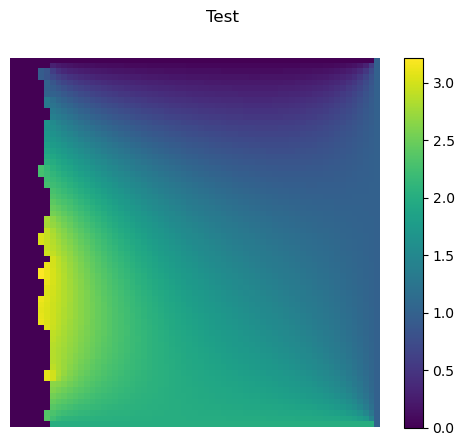

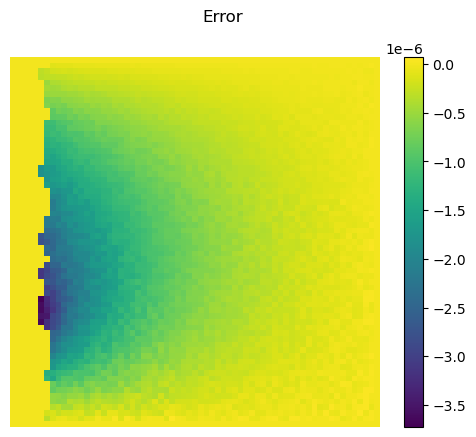

In [10]:
plot.plot_thermalfield(solution_test[0], "Solution")
plot.plot_thermalfield(u_mg_jac[0], "Test")
plot.plot_thermalfield(u_mg_jac[0]-solution_test[0], "Error")